In [4]:
import pandas as pd
import numpy as np

PATH = './drive/MyDrive/Colab Notebooks/Datasets/training.1600000.processed.noemoticon.csv'
# data from AI crowd: https://www.aicrowd.com/challenges/epfl-ml-text-classification
PATH_POS = './drive/MyDrive/Colab Notebooks/Datasets/train_pos_full.txt'
PATH_NEG = './drive/MyDrive/Colab Notebooks/Datasets/train_neg_full.txt'
PICKLE_PATH = './backup_sentiment'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# function to read the .txt file of the AI crowd data set
def get_new_tweets():
    pos= list()
    neg = list()
    with open(PATH_POS,errors = "ignore") as f:
        for line in f:
            pos.append(line.replace("\n",""))
    with open(PATH_NEG,errors = "ignore") as f:
        for line in f:
            neg.append(line.replace("\n",""))
    return pd.Series(np.array(pos)),pd.Series(np.array(neg))

In [7]:
tweet_pos,tweet_neg = get_new_tweets()

In [9]:
# importing the kaggle dataset
try:  
    tweets = pd.read_pickle(PICKLE_PATH)
except:
    header_list = ["target", "id", "date" ,"flag", "user", "text"]
    print("there is no backup")
    tweets = pd.read_csv(PATH, encoding = "ISO-8859-1", names=header_list)
    tweets.to_pickle(PICKLE_PATH)
    # tweet_pos,tweet_neg = get_new_tweets()

there is no backup


In [60]:
sentiment_num2name = {
     0: "Negative",
     2: "Neutral",
     4: "Positive",
}
tweets["target"] = tweets["target"].apply(lambda num: sentiment_num2name[num])
tweets.head()

,target,id,date,flag,user,text,month
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",4
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,4
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,4
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,4
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",4


In [10]:
tweets.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [176]:
import time
# adding a column called month with the number of the month
# this is done by applying an anonymous function to each row
# using the function time.streptime which converts a string date in the asctime format
# to a gm time structure
tweets['month'] = tweets['date'].apply(lambda x: time.strptime(x[0:19] + x[23:]).tm_mon)
tweets['hour'] = tweets['date'].apply(lambda x: time.strptime(x[0:19] + x[23:]).tm_hour)
tweets['weekday'] = tweets['date'].apply(lambda x: time.asctime(time.strptime(x[0:19] + x[23:]))[0:3])

In [232]:
tweets.head()

,target,id,date,flag,user,text,month,hour,weekday
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",4,22,Mon
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,4,22,Mon
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,4,22,Mon
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,4,22,Mon
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",4,22,Mon


In [177]:
# grouping the tweets per month
group_pos = tweets[tweets['target']=='Positive'].groupby(['month'])
group_neg = tweets[tweets['target']=='Negative'].groupby(['month'])
group_all = tweets.groupby(['month'])

In [178]:
# counting the number of positive, negative and all tweets in each months
y_pos = group_pos.count()['id']
y_neg = group_neg.count()['id']
y_all = group_all.count()['id']

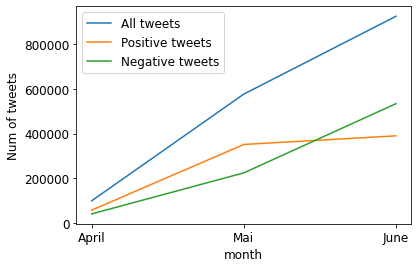

In [179]:
# plotting the number of tweets per months
from matplotlib import pyplot as plt
plt.plot(np.arange(4,7), y_all) 
plt.plot(np.arange(4,7), y_pos)
plt.plot(np.arange(4,7), y_neg)
plt.legend(['All tweets', 'Positive tweets', 'Negative tweets'])
plt.xticks([4, 5, 6], ['April', 'Mai', 'June'])
plt.xlabel('month')
plt.ylabel('Num of tweets')
plt.rcParams.update({'font.size': 12})
plt.savefig('tweets_april_mai_june', dpi = 300)

In [235]:
# calculating the number of tweet per hour on each day of the week
days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
time = list(np.arange(23))
num_tweet_all = np.zeros((len(days), len(time)))
num_tweet_pos = np.zeros((len(days), len(time)))
num_tweet_neg = np.zeros((len(days), len(time)))
for i in range(len(days)):
    # counts the number of occurence of each hour
    # .value_counts() returns the occurences of hours which need to be reordered by evaluating it at "time"
    num_tweet_all[i] = np.array(tweets[tweets['weekday']==days[i]]['hour'].value_counts()[time])
    # The following two lines didn't work because the dataset has no positive or negative tweets at some hours
    # It seems the data set was manipulated to balance the number of positive and negatice tweets
    # This results in non uniformous distribution of positive and negative tweets in time
    # num_tweet_pos[i] = np.array(tweets[(tweets['weekday']==days[i]) & (tweets['target']=='Positive')]['hour'].value_counts()[time])
    # num_tweet_neg[i] = np.array(tweets[(tweets['weekday']==days[i]) & (tweets['target']=='Negative')]['hour'].value_counts()[time])

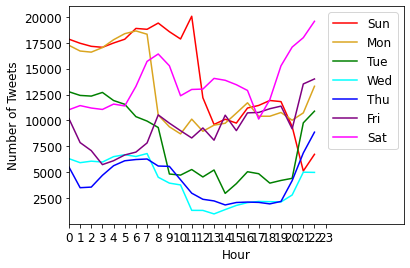

In [242]:
# plotting the number of tweets per hour on each day of the week
fig, ax = plt.subplots()
ax.set_prop_cycle(color = ['red', 'goldenrod', 'green', 'cyan', 'blue', 'purple', 'magenta'])
plt.plot(time,num_tweet_all.T)
plt.legend(days)
plt.ylabel('Number of Tweets')
plt.xlabel('Hour')
plt.xticks(np.linspace(0,23,24));
plt.xlim((0, 30))
plt.savefig('tweets_per_hour', dpi = 300)

In [61]:
# Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

# Building classification models
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# Model evaluation
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [63]:
X_all = tweets["text"]
y_all = tweets["target"]
len_pos = len(tweet_pos)
len_neg = len(tweet_neg)
X_all = X_all.append(tweet_pos)
X_all =X_all.append(tweet_neg)
y_all =y_all.append(pd.Series(np.array(['Positive']*len_pos)))
y_all =y_all.append(pd.Series(np.array(['Negative']*len_neg)))
y_all

0          Negative
1          Negative
2          Negative
3          Negative
4          Negative
             ...   
1249995    Negative
1249996    Negative
1249997    Negative
1249998    Negative
1249999    Negative
Length: 4100000, dtype: object

In [64]:

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.25, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [65]:
tfidf = TfidfVectorizer()
tfidf.fit_transform(X_train)

<2767500x810276 sparse matrix of type '<class 'numpy.float64'>'
	with 32696184 stored elements in Compressed Sparse Row format>

In [66]:
def train(tfidf, model, train_data, train_labels, test_data):
    model.fit(tfidf.transform(train_data), train_labels)
    preds = model.predict(tfidf.transform(test_data))
    
    return preds

In [67]:
def grade(model, preds, test_labels):
    print(metrics.classification_report(test_labels, preds))
    
    cm = confusion_matrix(test_labels, preds)
    cm_normd = cm / cm.sum(axis=1).reshape(-1, 1)
    
    heatmap_kwargs = dict(
        cmap="YlGnBu",
        xticklabels=model.classes_,
        yticklabels=model.classes_,
        vmin=0.,
        vmax=1.,
        annot=True,
        annot_kws={"size": 10},
    )
    
    sns.heatmap(cm_normd, **heatmap_kwargs)
    
    plt.title(f"{model.__class__.__name__} Classification")
    plt.ylabel("Ground-truth labels")
    plt.xlabel("Predicted labels")
    plt.plot()

In [68]:
def train_and_grade(tfidf, model, train_data, train_labels, test_data, test_labels):
    preds = train(tfidf, model, train_data, train_labels, test_data)
    grade(model, preds, test_labels)

              precision    recall  f1-score   support

    Negative       0.81      0.80      0.81    153794
    Positive       0.80      0.82      0.81    153706

    accuracy                           0.81    307500
   macro avg       0.81      0.81      0.81    307500
weighted avg       0.81      0.81      0.81    307500



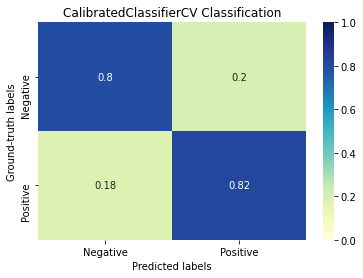

In [69]:
svm_lsvc = LinearSVC(class_weight="balanced")
clf = CalibratedClassifierCV(svm_lsvc)
train_and_grade(tfidf, clf, X_train, y_train, X_valid, y_valid)

In [71]:
import pickle
pickle.dump(clf, open( "save.p", "wb" ) )

In [72]:
preds = clf.predict(tfidf.transform(X_test))
preds_proba = clf.predict_proba(tfidf.transform(X_test))

In [78]:
preds

array(['Negative', 'Negative', 'Negative', ..., 'Negative', 'Negative',
       'Positive'], dtype='<U8')

(array([502239.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 522761.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

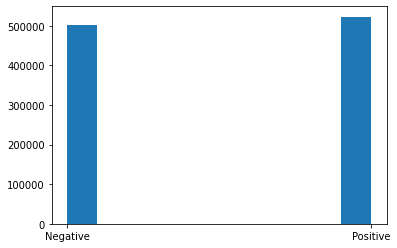

In [73]:
plt.hist(preds)

In [87]:
pred_neut

array(['Negative', 'Negative', 'Negative', ..., 'Neutral', 'Negative',
       'Positive'], dtype='<U8')

(array([436673.,      0.,      0.,      0.,      0., 454451.,      0.,
             0.,      0., 133876.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

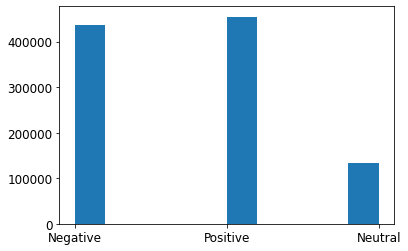

In [174]:
f = lambda x: 'Negative' if x>0.6 else ('Neutral' if x>0.4 else 'Positive')
pred_neut = np.array([f(xi) for xi in preds_proba[:,0]])
plt.hist(pred_neut)

In [ ]:
!pip install fasttext

     |████████████████████████████████| 71kB 3.3MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3039080 sha256=d2f92a2434dab33370b44bc8adf6e51b772d25cebbe965b8e2189577d40ee024
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [ ]:
import fasttext

In [ ]:
def shuffle(series):
  series.index = np.linspace(0, len(series)-1, len(series))
  series = series.iloc[np.random.permutation(len(pos_))]
  series.index = np.linspace(0, len(series)-1, len(series))
  return series

In [ ]:
test_percentage = 0.1
validate_percentage = 0.1
pos = shuffle(X_all[y_all==4])
neg = shuffle(X_all[y_all==0])

num_neg_test = int(test_percentage * len(neg) )
num_neg_validate = int(test_percentage * len(neg) )

num_pos_test = int(test_percentage * len(pos) )
num_pos_validate = int(validate_percentage * len(pos) )

In [ ]:
try:
    fileTrain = open("train.txt","w",errors="namereplace")
    fileValid = open("valid.txt","w",errors="namereplace")
    fileTest = open("test.txt","w",errors="namereplace")
    print("pos ",len(pos),"neg",len(neg))
    i = 0
    for neg_line in neg:
        # if i % 1e5==0: print(neg_line,'\n') 
        if (i < num_neg_test):
            fileTest.write("__label__0 "+(neg_line)+"\n")
        elif (i < num_neg_test + num_neg_validate):
            fileValid.write("__label__0 "+(neg_line)+"\n")
        else:
            fileTrain.write("__label__0 "+(neg_line)+"\n")
        i +=1
    i = 0 
    for pos_line in pos:
        # if i % 1e5==0: print(pos_line,'\n') 
        if(i < num_neg_test):
            fileTest.write("__label__4 "+(pos_line)+"\n")
        elif (i < num_neg_test + num_neg_validate):
            fileValid.write("__label__4 "+(pos_line)+"\n")
        else:
            fileTrain.write("__label__4 "+(pos_line)+"\n")
        i +=1
# except:
#     print("Error try again",flush = True)
finally:
    fileTrain.close()
    fileValid.close()
    fileTest.close()

pos  2050000 neg 2050000


In [ ]:
model = fasttext.train_supervised(input = "ready_for_fasttext.txt",autotuneValidationFile = "valid_fastText.txt")

In [ ]:
model_no_val = fasttext.train_supervised(input = "train.txt")

In [ ]:
hyper_params = {"lr": 0.01,
    "epoch": 70,
    "wordNgrams": 2,
    "dim": 20}

In [ ]:
model_hyper = fasttext.train_supervised(input="train.txt", **hyper_params)

In [ ]:
model.test("test.txt")

(410000, 0.5007780487804878, 0.5007780487804878)

In [ ]:
model.test("train.txt")

(3280000, 0.5041326219512196, 0.5041326219512196)

In [ ]:
model.test("valid.txt")

(410000, 0.503980487804878, 0.503980487804878)

In [ ]:
def test_model(model,test_set):
  correct = 0
  for i in range(len(test_set)):
    if model.predict(test_set['text'][i])[0][0] == '__label__4':
      temp = 4
    else:
      temp = 0
    if temp == test_set['target'][i]:
      correct = correct + 1

  accuracy = correct/len(test_set)
  return accuracy

In [ ]:
test_model(model)

In [ ]:
test_model(model_no_val)

0.5059853366568944

In [ ]:
test_model(model_hyper)

0.5893873688421032